<a href="https://colab.research.google.com/github/Ghifarahadian/concurrent-activity-recognition/blob/master/CNNLSTM_2Layers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
IS_COLAB = True

In [ ]:
import sys
import os
import gc
import torch
import pandas as pd
import numpy as np
import glob
import math

import matplotlib.pyplot as plt
from torch.utils.data.dataset import random_split
from torch.utils.data import Dataset, DataLoader

import torch.nn as nn
import torch.nn.functional as F
import torch

from sklearn import metrics

# Log progress
def log_progress(sequence, every=None, size=None, name='Items'):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = int(size / 200)     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{name}: {index} / ?'.format(
                        name=name,
                        index=index
                    )
                else:
                    progress.value = index
                    label.value = u'{name}: {index} / {size}'.format(
                        name=name,
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = "{name}: {index}".format(
            name=name,
            index=str(index or '?')
        )

if IS_COLAB:
    # using google colab
    from google.colab import drive
    drive.mount('/content/drive')
    ROOT = os.path.join('/content', 'drive', 'My Drive',
                        'concurrent-activity-recognition')
    os.chdir(ROOT)
else:
    # using own pc
    ROOT = os.path.join(os.getcwd(), 'concurrent-activity-recognition')
    os.chdir(ROOT)

print(ROOT)

if torch.cuda.is_available():
    device = torch.device("cuda:0")  # you can continue going on here, like cuda:1 cuda:2....etc. 
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/concurrent-activity-recognition
Running on the GPU


In [ ]:
class OpportunityDatasetParsed(Dataset):
    def __init__(self, filenames):
        self.filenames = filenames
        
    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, index):
        filename = self.filenames[index]
        print(filename)

        df = pd.read_csv(filename, header = 0)

        # first 15 columns are for data
        data = torch.FloatTensor(
            df.iloc[:, 0:15].values.astype('float'))
                
        # last 3 columns are for label
        label = torch.FloatTensor(
            df.iloc[29, 15:18].values.astype('float'))

        return data, label

In [ ]:
# grid search
conv1_outchs = [20]
conv1_sizes = [3]
conv2_outchs = [40]
conv2_sizes = [3]
lstm1_hs = [20]
learning_rates = [0.001]

grids = [(conv1_outch, conv1_size, conv2_outch,
         conv2_size, lstm1_h, learning_rate)
        for conv1_outch in conv1_outchs
        for conv1_size in conv1_sizes
        for conv2_outch in conv2_outchs
        for conv2_size in conv2_sizes
        for lstm1_h in lstm1_hs
        for learning_rate in learning_rates
        ]

#grids = [(30, 3, 60, 3, 20, 0.1), (20, 3, 60, 3, 30, 0.1)]
len(grids)

1

In [ ]:
# dataset constants
data_row_n = 30
data_feature_n = 15
data_output1_n = 3

# training hyperparameter
num_epochs = 10
batch_size = 1

class CNN_LSTM(nn.Module):
    def __init__(self, grid):
        super(CNN_LSTM, self).__init__()
        conv1_outch = grid[0]
        conv1_size = grid[1]
        conv1_outlen = data_row_n - (conv1_size - 1)
        conv2_outch = grid[2]
        conv2_size = grid[3]
        conv2_outlen = conv1_outlen - (conv2_size - 1)
        lstm1_h = grid[4]
        self.lstm1_h = lstm1_h
        lstm1_hlen = conv2_outlen
        self.lstm1_hlen = lstm1_hlen

        self.conv1 = nn.Conv1d(data_feature_n, conv1_outch, conv1_size)
        self.conv2 = nn.Conv1d(conv1_outch, conv2_outch, conv2_size)
        self.lstm1 = nn.LSTM(conv2_outch, lstm1_h)
        self.fc1 = nn.Linear(lstm1_h*lstm1_hlen, data_output1_n)

    def forward(self, x, h):
        batch_len = x.shape[0]
        x.transpose_(1, 2)
        x = F.relu(self.conv1(x), inplace=False)
        x = F.relu(self.conv2(x), inplace=False)
        x.transpose_(1, 2)
        x, _ = self.lstm1(x, h)
        #print(x.shape)
        x = x.reshape([batch_len, -1])
        #print(x.shape)
        out = self.fc1(x)
        #print(x.shape)
        return out

    def init_hidden(self):
        weight = next(self.parameters()).data
        hidden = (weight.new(1, self.lstm1_hlen,
                             self.lstm1_h).zero_().to(device),
                  weight.new(1, self.lstm1_hlen,
                             self.lstm1_h).zero_().to(device))
        return hidden

# try to use this paper instead lul
class CNN_Custom(nn.Module):
    def __init__(self):
        super(CNN_Custom, self).__init__()
        self.conv1 = nn.Conv2d(1, 50, (1, 5))
        self.pool1 = nn.MaxPool2d((1, 2))
        self.conv2 = nn.Conv2d(50, 40, (1, 5))
        self.pool2 = nn.MaxPool2d((1, 3))
        self.conv3 = nn.Conv2d(40, 20, (1, 3))
        self.fc1 = nn.Linear(300, 3)

    def forward(self, x):
        batch_len = x.shape[0]
        #print(x.shape)
        x = x.reshape(x.shape[0], 1, x.shape[1], x.shape[2])
        #print(x.shape)
        x.transpose_(2, 3)
        for p in self.conv1.parameters():
            if p.requires_grad:
                print(p.name, p.data)
        #print(.parameters().data)
        print(x)
        x = F.relu(self.conv1(x))
        print(x)
        x = self.pool1(x)
        #print(x.shape)
        x = F.relu(self.conv2(x))
        #print(x)
        x = self.pool2(x)
        #print(x.shape)
        x = F.relu(self.conv3(x))
        #print(x)
        x = x.reshape([batch_len, -1])
        #print(x.shape)
        x = self.fc1(x)
        #print(x.shape)
        return x

def make_train_step(model, loss_fn, optimizer):
    def train_step(data, labels):
        model.train()
        optimizer.zero_grad()

        data, labels = data.to(device), labels.to(device)

        data = torch.reshape(data, (len(labels), -1, 15))

        label1 = torch.reshape(labels[:, 0:1].long(), (-1,))
        
        output1 = model(data)

        loss = loss_function(output1, label1)
        loss.backward()
        optimizer.step()
        return loss.item()

    return train_step

Streaming output truncated to the last 5000 lines.
            7.7551e-01, -6.2765e-01,  2.0680e+00,  1.8819e+00,  2.7118e+00],
          [ 2.6790e+00,  1.8763e+00,  1.5156e+00,  1.3962e+00,  1.2409e+00,
            1.0641e+00,  7.6553e-01,  3.7616e-01,  2.4238e-01, -1.2310e-01,
           -4.8859e-01, -5.0531e-01, -8.4691e-01, -1.3223e+00, -1.2411e+00,
           -1.0213e+00, -9.6635e-01, -1.0117e+00, -6.4625e-01, -3.8348e-01,
           -3.6198e-01, -1.2721e+00,  3.5036e-03, -1.8521e-01,  6.8001e-02,
           -3.6628e-03,  2.3044e-01, -7.8002e-01, -4.1884e-02, -2.5688e-01]]]],
       device='cuda:0')
tensor([[[[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          ...,
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan, nan, nan]],

         [[nan, nan, nan,  ..., nan, nan, nan],
          [nan, nan, nan,  ..., nan

KeyboardInterrupt: ignored

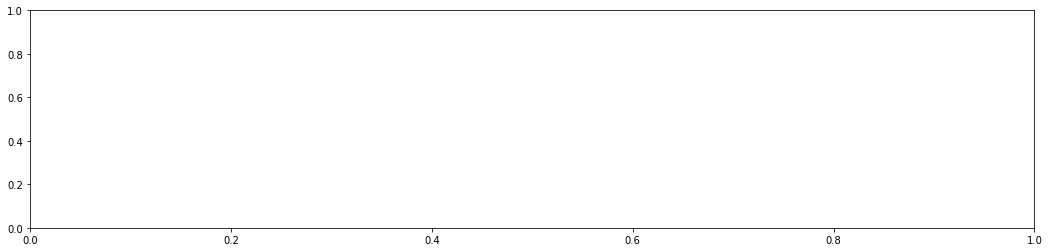

In [ ]:
# Training and validation, by using grid search
torch.manual_seed(69)
models = []
fig, axs = plt.subplots(len(grids), figsize=(18, 4*len(grids)))
i = 0
for grid in grids:
    #model = CNN_LSTM(grid).to(device)
    model = CNN_Custom().to(device)
    loss_function = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=grid[5])
    train_step = make_train_step(model, loss_function, optimizer)

    data_train_files = glob.glob("dataset_parsed/train/*.csv")
    #h = model.init_hidden()
    train_losses = []
    val_losses = []

    # TODO: Need to do the splitting better
    data_train = OpportunityDatasetParsed(data_train_files)
    train_dataset, val_dataset = random_split(data_train,
            [math.ceil(0.8*len(data_train)), math.floor(0.2*len(data_train))])

    for epoch in log_progress(range(num_epochs), name="Epoch"):
    #for epoch in range(num_epochs):
        #print("Epoch " + str(epoch + 1))

        dataloader_train = DataLoader(train_dataset, batch_size=batch_size,
                        shuffle=True)

        train_losses_temp = []
        #for data, labels in log_progress(dataloader_train, name="Training"):
        for data, labels in dataloader_train:
            loss = train_step(data, labels)
            #print(loss)
            train_losses_temp.append(loss)

        train_losses.append(np.mean(train_losses_temp))

        with torch.no_grad():
            dataloader_val = DataLoader(val_dataset, batch_size=batch_size,
                            shuffle=False)
            
            val_losses_temp = []
            for data, labels in dataloader_val:
                model.eval()
                data, labels = data.to(device), labels.to(device)

                label1 = torch.reshape(labels[:, 0:1].long(), (-1,))

                output1 = model(data)
                #print(output1)

                val_loss = loss_function(output1, label1)
                val_losses_temp.append(val_loss.item())
            
            val_losses.append(np.mean(val_losses_temp))

    models.append(model)

    try:
        axs[i].plot(range(0, num_epochs), train_losses, label="train_loss")
        axs[i].plot(range(0, num_epochs), val_losses, label="val_loss")
        axs[i].set_title(grid)
    except:
        axs.plot(range(0, num_epochs), train_losses, label="train_loss")
        axs.plot(range(0, num_epochs), val_losses, label="val_loss")
        axs.set_title(grid)
    i += 1

plt.legend()

In [ ]:
train_losses

[nan, nan, nan, nan, nan, nan]

In [ ]:
data_test_files = glob.glob("dataset_parsed/test/*.csv")
data_test = OpportunityDatasetParsed(data_test_files)

i = 0
for model in models:
    with torch.no_grad():
        #h = model.init_hidden()
        dataloader_test = DataLoader(data_test, batch_size=batch_size,
                        shuffle=False)
        
        label1_all = []
        predicted1_all = []

        for data, labels in log_progress(dataloader_test, name="Testing"):
            model.eval()
            data, labels = data.to(device), labels.to(device)

            label1 = torch.reshape(labels[:, 0:1].long(), (-1,))
            label1_all.extend(label1.tolist())

            output1 = model(data)

            _, predicted1 = torch.max(output1, 1)

            predicted1_all.extend(predicted1.tolist())
        
        print("Grid: {}".format(grids[i]))
        i += 1
        print("Accuracy: {}".format(metrics.accuracy_score(label1_all, predicted1_all)))
        print("F1 (micro): {}".format(metrics.f1_score(label1_all, predicted1_all, average='micro')))
        print("F1 (macro): {}".format(metrics.f1_score(label1_all, predicted1_all, average='macro')))
        print("F1 (weighted): {}".format(metrics.f1_score(label1_all, predicted1_all, average='weighted')))



KeyboardInterrupt: ignored

In [ ]:
label1_all

[1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 2,
 2,
 2,
 2,
 1,
 0,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 1,
 0,
 2,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,


No handles with labels found to put in legend.


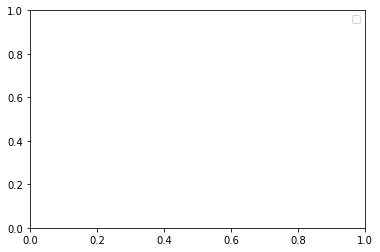

In [ ]:
axs.plot(range(0, num_epochs), train_losses, label="train_loss")
axs.plot(range(0, num_epochs), val_losses, label="val_loss")

plt.legend()

In [ ]:
test = torch.FloatTensor([[1, 2], [1, 2], [1, 2], [1, 2]])

In [ ]:
test.transpose(0, 1)

tensor([[1., 1., 1., 1.],
        [2., 2., 2., 2.]])

In [ ]:
torch.randn(3, 5, requires_grad=True)

tensor([[ 1.4448,  1.1153, -0.3726,  1.3726, -0.1775],
        [ 0.3801,  0.0387, -1.7176,  0.6296,  1.6406],
        [ 0.5300, -0.4268,  0.1901, -0.6905, -0.8405]], requires_grad=True)

In [ ]:
torch.empty(3, dtype=torch.long).random_(5)

tensor([0, 2, 1])